# TP 1 Mesures de performance
Dans ce TP, nous aimerions avoir un premier aperçu sur les algorithmes d'apprentissage automatique. Plus précisément, nous aimerions évaluer leurs performances en utilisant les métriques suivantes:
- Matrice de conusion
- Rappel
- Précision
- Taux de FP
- Spécificité
- Courbe ROC

Les mesures devront être calculées sur la tâche de classification de nombres manuscrits.

Le travail consiste à implementer ces métriques et à les comparer avec les métriques des librairies disponibles.

Les algorithmes : K plus Proches Voisins devront être implementés.

# Importation des librairies necessaires au travail

In [80]:
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from numpy import random
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [81]:
# Pour RNC
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import SGD

# Lecture des fichiers de données à classifier
Pour ce TP, nous allons lire les données à partir d'un fichier csv.

In [107]:
# données
X = np.genfromtxt('data.csv', delimiter=',', dtype=int) # function that reads data from a tX_train file and stores it in an array, data is loaded as integers
print(X.shape) # numbers of rows and columns
df = pd.read_csv("data.csv",nrows=5000) # loads 5000 rows of data into a panda dataframe

(5000, 400)


In [108]:
# étiquettes
Y = np.genfromtxt('labels.csv', delimiter=',', dtype=int)
Y.shape # 5000 labels corresponding to the data.csv rows respectivily

(5000,)

Afficher aléatoirement quelques données de notre base

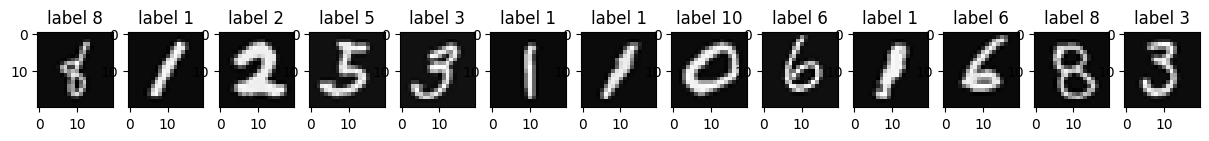

In [84]:
plt.figure(figsize=(15,8))
for i in range(13): #note: each 500 lines, there is a new value
    c = random.randint(X.shape[0]) #pick a random line from the dataset 
    a = X[c,:].reshape((20, 20)) #shape of one number in the image 
    a=np.transpose(a) # la transposé (rendre les ligne des colonne et vice versa)
    plt.subplot(1,13,i+1)
    plt.title('label '+ str(Y[c]))
    plt.imshow(a,cmap='gray')

Notons que l'étiquette 10 concerne le chiffre 0. L'étiquette a été utilisée ainsi afin de faciliter les calculs conséquents.

# Implémentation des métriques demandées
Ici il faut écrire les fonctions, puis les appeler dans la suite du code

- Matrice de confusion :

##### Global Matrix for all classes
10 X 10 matrix where : \
row : true class \
column : predicted class \
diagonal elements represent the correct predictions \
off diagnoal elements represent misclassifications

In [85]:
def compute_confusion_matrix(y_true, y_pred, num_classes):
    """
    Compute the confusion matrix from scratch.

    Args:
        y_true (array): True labels 
        y_pred (array): Predicted labels
        num_classes (int): Number of classes.

    Returns:
        confusion_matrix (array): Confusion matrix of shape [num_classes, num_classes].
        the 10th row of the matrix represents the class 10 (digit 0)
    """
    # Initialize the confusion matrix with zeros
    cm = np.zeros((num_classes, num_classes), dtype=int)
    
    # Iterate through the true and predicted labels
    for true_label, pred_label in zip(y_true, y_pred):
        # Adjust labels to be 0-based (0-based indexing)
        true_label_idx = true_label - 1  # Convert 1-10 to 0-9
        pred_label_idx = pred_label - 1  # Convert 1-10 to 0-9
        
        # Increment the corresponding cell in the confusion matrix
        cm[true_label_idx, pred_label_idx] += 1
    
    return cm      

##### Matrix for each class
we will generate 10 different matrices of 2X2 \
True Positive (TP)  False Negative (FN) \
False Positive (FP) True Negative (TN) 



In [86]:
def confusion_matrix_per_class(y_true, y_pred, num_classes):
    """
    Compute the confusion matrix for each class (one-vs-all).

    Args:
        y_true (array): True labels 
        y_pred (array): Predicted labels 
        num_classes (int): Number of classes.

    Returns:
        class_cm (dict): A dictionary where keys are class labels and values are 2x2 confusion matrices.
    """
    class_cm = {}
    
    for class_label in range(1, num_classes + 1): # num_classes +1 = 11 : because in range should go from 1 to 10
        # Create binary labels for the current class : 1 for current class , 0 for other classes
        y_true_binary = (y_true == class_label).astype(int)  # as type converts boolean value true or false to 1 or 0
        y_pred_binary = (y_pred == class_label).astype(int)
        
        # Compute the 2x2 confusion matrix for the current class
        tp = np.sum((y_true_binary == 1) & (y_pred_binary == 1))  # True Positives
        tn = np.sum((y_true_binary == 0) & (y_pred_binary == 0))  # True Negatives
        fp = np.sum((y_true_binary == 0) & (y_pred_binary == 1))  # False Positives
        fn = np.sum((y_true_binary == 1) & (y_pred_binary == 0))  # False Negatives
        
        # Store the confusion matrix for the current class
        class_cm[class_label] = np.array([[tn, fp], [fn, tp]])
     
    return class_cm

- Accuracy = (TP + TN)/(TP + TN + FP + FN)

##### Overall accuracy

In [87]:
def overall_accuracy(y_true,y_pred):
  correct_predictions = 0 # initialise counter for correct predictions TP+TN
  for i in range(len(y_true)):
    if(y_true[i]== y_pred[i]):
      correct_predictions +=1
  
  overall_accuracy = correct_predictions / len(y_true) # len(y_true) = TP + TN + FP + FN

  return(overall_accuracy)

##### accuracy for each class

In [88]:
def accuracy_per_class(y_true, y_pred, num_classes):
    """
    Compute accuracy for each class.

    Args:
        y_true (array): True labels 
        y_pred (array): Predicted labels 
        num_classes (int): Number of classes.

    Returns:
        class_accuracy (dict): A dictionary where keys are class labels and values are accuracies.
    """
    class_accuracy = {}
    
    for class_label in range(1, num_classes + 1):  # Classes are labeled from 1 to num_classes
        # Indices of samples that belong to the current class
        class_indices = (y_true == class_label) # boolean values 0 or 1 for rows of y_true corresponding to the class
        
        # Number of samples for the current class
        total_samples = np.sum(class_indices) # sum of boolean values is going to be number of rows of the class
        
        if total_samples == 0:
            # If there are no samples for this class, set accuracy to 0 or handle it as needed
            class_accuracy[class_label] = 0. # float
            continue
        
        # Number of correct predictions for the current class
        correct_predictions = np.sum((y_true == class_label) & (y_pred == class_label))
        
        # Accuracy for the current class
        accuracy = correct_predictions / total_samples
        class_accuracy[class_label] = accuracy
    
    return class_accuracy

- Recall (True Positive Rate) = TP/(TP + FN)

##### Recall for each class

In [89]:
def recall_per_class(y_true, y_pred, num_classes):
    """
    Compute recall for each class.

    Args:
        y_true (array): True labels 
        y_pred (array): Predicted labels 
        num_classes (int): Number of classes.

    Returns:
        class_recall (dict): A dictionary where keys are class labels and values are recall values.
    """
    class_recall = {}
    
    for class_label in range(1, num_classes + 1):  # Classes are labeled from 1 to num_classes
        # True Positives (TP): Correctly predicted as the current class
        tp = np.sum((y_true == class_label) & (y_pred == class_label))
        
        # False Negatives (FN): Belong to the current class but predicted as another class
        fn = np.sum((y_true == class_label) & (y_pred != class_label))
        
        # Avoid division by zero
        if (tp + fn) == 0:
            recall = 0.0  # If there are no samples for this class, set recall to 0
        else:
            # Compute recall
            recall = tp / (tp + fn)
        
        # Store the recall for the current class
        class_recall[class_label] = recall
    
    return class_recall

##### Overall Recall 

In [90]:
def overall_recall(y_true, y_pred, num_classes):
    """
    Compute overall recall.

    Args:
        y_true (array): True labels 
        y_pred (array): Predicted labels 
        num_classes (int): Number of classes.

    Returns:
        overall_recall (float): Overall recall.
    """
    # Initialize variables to store total TP and FN
    total_tp = 0
    total_fn = 0
    
    # Iterate over each class
    for class_label in range(1, num_classes + 1):
        # True Positives (TP): Correctly predicted as the current class
        tp = np.sum((y_true == class_label) & (y_pred == class_label))
        total_tp += tp
        
        # False Negatives (FN): Belong to the current class but predicted as another class
        fn = np.sum((y_true == class_label) & (y_pred != class_label))
        total_fn += fn
    
    # Compute overall recall
    if (total_tp + total_fn) == 0:
        overall_recall = 0.0  # Avoid division by zero
    else:
        overall_recall = total_tp / (total_tp + total_fn)
    
    return overall_recall

- Précision = TP/(TP + FP)

##### Precision for each class


In [91]:
def precision_per_class(y_true, y_pred, num_classes):
    
    class_precision = {}
        
    for class_label in range(1, num_classes + 1):  # Classes are labeled from 1 to num_classes
         # True Positives (TP): Correctly predicted as the current class
        TP = np.sum((y_true == class_label) & (y_pred == class_label))
         # False Positives (FP): Predicted as this class but actually not this class
        FP = np.sum((y_pred == class_label) & (y_true != class_label))
        
        # Avoid division by zero
        if (TP + FP) == 0:
            precision = 0.0  # If there are no samples for this class, set precison to 0
        else:
            # Compute precision
            precision = TP / (TP + FP)
         
        # Store the precision for the current class
        class_precision[class_label] = precision
    
    return class_precision
    

##### Overall Precision

In [92]:
def overall_precision(y_true, y_pred, num_classes):
    
    # Initialize variables to store total TP and FP
    total_TP = 0
    total_FP = 0
    
    # Iterate over each class
    for class_label in range(1, num_classes + 1):
        # True Positives (TP): Correctly predicted as the current class
        tp = np.sum((y_true == class_label) & (y_pred == class_label))
        total_TP += tp
        
         # False Positives (FP): Predicted as this class but actually not this class
        FP = np.sum((y_pred == class_label) & (y_true != class_label))
        total_FP += FP
    
    # Compute overall precision
    if (total_TP + total_FP) == 0:
        overall_precision = 0.0  # Avoid division by zero
    else:
        overall_precision = total_TP / (total_TP + total_FP)
    
    return overall_precision

- Taux de FP (False Positive Rate) = FP / (FP + TN)

##### False Positive Rate for each class

In [93]:
def FP_rate_per_class(y_true, y_pred, num_classes):
    
    class_FP_rate = {}
        
    for class_label in range(1, num_classes + 1):  # Classes are labeled from 1 to num_classes
          # False Positives (FP): Predicted as this class but actually not this class
        FP = np.sum((y_pred == class_label) & (y_true != class_label))
         # True Negatives (TN)
        TN = np.sum((y_true != class_label) & (y_pred != class_label))
        
        # Avoid division by zero
        if (TN + FP) == 0:
            FP_rate = 0.0  # If there are no samples for this class, set FP_rate to 0
        else:
            # Compute FP_rate
            FP_rate = FP / (FP + TN)
         
        # Store the FP_rate for the current class
        class_FP_rate[class_label] = FP_rate
    
    return class_FP_rate
    

##### Overall False Positive Rate

In [94]:
def overall_FP_rate(y_true, y_pred, num_classes):
    
    # Initialize variables to store total TN and FP
    total_TN = 0
    total_FP = 0
    
    # Iterate through each class
    for class_label in range(num_classes):  # Classes from 0 to num_classes-1
        # False Positives (FP): Predicted as this class but actually not this class
        FP = np.sum((y_pred == class_label) & (y_true != class_label))
        total_FP += FP
        
        # True Negatives (TN): Neither of this class, nor predicted as this class
        TN = np.sum((y_true != class_label) & (y_pred != class_label))
        total_TN += TN
    
    # Compute the overall false positive rate (FPR)
    if (total_FP + total_TN) == 0:
        overall_FP_rate = 0.0  # Avoid division by zero
    else:
        overall_FP_rate = total_FP / (total_FP + total_TN)
    
    return overall_FP_rate


- Spécificité (True Negative Rate) = TN / (TN + FP)

##### Specificity for each class

In [95]:
def Specificity_per_class(y_true, y_pred, num_classes):
    
    class_Specificity = {}
        
    for class_label in range(1, num_classes + 1):  # Classes are labeled from 1 to num_classes
          # False Positives (FP): Predicted as this class but actually not this class
        FP = np.sum((y_pred == class_label) & (y_true != class_label))
         # True Negatives (TN)
        TN = np.sum((y_true != class_label) & (y_pred != class_label))
        
        # Avoid division by zero
        if (TN + FP) == 0:
            Specificity = 0.0  # If there are no samples for this class, set Specificity to 0
        else:
            # Compute Specificity
            Specificity = TN / (FP + TN)
         
        # Store the Specificity for the current class
        class_Specificity[class_label] = Specificity
    
    return   class_Specificity
    

##### Overall Specificity 

In [96]:
def overall_Specificity(y_true, y_pred, num_classes):
    
    # Initialize variables to store total TN and FP
    total_TN = 0
    total_FP = 0
    
    # Iterate through each class
    for class_label in range(num_classes):  # Classes from 0 to num_classes-1
        # False Positives (FP): Predicted as this class but actually not this class
        FP = np.sum((y_pred == class_label) & (y_true != class_label))
        total_FP += FP
        
        # True Negatives (TN): Neither of this class, nor predicted as this class
        TN = np.sum((y_true != class_label) & (y_pred != class_label))
        total_TN += TN
    
    # Compute the overall Specificity
    if (total_FP + total_TN) == 0:
        overall_Specificity = 0.0  # Avoid division by zero
    else:
        overall_Specificity = total_TN / (total_FP + total_TN)
    
    return overall_Specificity

- Courbe ROC

In [97]:
def roc_curve(actual, predicted_probabilities, positive_label):
    """
    Compute the ROC curve for a specific class.

    Args:
    actual (array-like): Ground truth labels.
    predicted_probabilities (array-like): Predicted probabilities for the target class.
    positive_label (int): The class considered as positive.

    Returns:
    tuple: Lists of FPR and TPR values.
    """
    # Generate thresholds from the predicted probabilities
    thresholds = sorted(set(predicted_probabilities), reverse=True)
    
    tpr_list = []  # True Positive Rate values
    fpr_list = []  # False Positive Rate values
    
    for threshold in thresholds:
        # Convert probabilities into binary predictions based on the threshold
        predicted_labels = [1 if prob >= threshold else 0 for prob in predicted_probabilities]
        
        # Compute TPR (Recall) and FPR
        tp = sum((actual == positive_label) & (predicted_labels == 1))
        fn = sum((actual == positive_label) & (predicted_labels == 0))
        fp = sum((actual != positive_label) & (predicted_labels == 1))
        tn = sum((actual != positive_label) & (predicted_labels == 0))
        
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        
        # Append values to lists
        tpr_list.append(tpr)
        fpr_list.append(fpr)

    return fpr_list, tpr_list


##### affichage de la courbe 

In [98]:
def plot_roc_curve(fpr, tpr, positive_label):
    """
    Plot the ROC curve using Matplotlib.

    Args:
    fpr (list): List of False Positive Rates.
    tpr (list): List of True Positive Rates.
    positive_label (int): The class being analyzed.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, marker='o', linestyle='-', color='b', label=f'Class {positive_label}')
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')  # Diagonal line for reference
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title(f"ROC Curve for Class {positive_label}")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


# Classification

Définir d'abord la base d'entrainement X_train, Y_train et la base de test X_traint, Y_traint

In [109]:
scaler = StandardScaler()
scaler.fit(X)
scaled_features = scaler.transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(
      scaled_features, Y, test_size = 0.30)

# Méthode 0: K- Plus Proches Voisins

Ici il faudra implémenter la méthode, puis la tester et vérifier les métriques en variant le nombre K

### implementer la fonction qui calcule la distance Euclidienne

In [ ]:
def euclidean_distance(point1 : np.ndarray , point2 : np.ndarray)-> float:
    """
    Calculate the euclidien distance between two points (numpy arrays)
    """
    if point1.shape != point2.shape :
        raise ValueError("Both points must have same dimentions")
    
    distance =  np.sqrt(np.sum((point1 - point2)**2))
    return distance

#test 
a = np.array([5 , 3 ]); 
b = np.array([2 , 12 ]); 

print(euclidean_distance(a , b))

9.486832980505138


### Implementer l'algorithme KNN

In [101]:
def KNN(new_point : np.array , data : np.array , lables :np.array, k:int):
    """
    This function uses the K-Nearest Neighbors (KNN) algorithme to predict the lable of new_point
        new_point : is the data we want to classify
        data : a numpy array containes samples of lables data (only the features)
        lables : the lables of data
        k: The number of nearest neighbors to consider.
    """
    distances = []
    # 1. Calculate euclidienne distance with each point of the dataset 

    for i in range(data.shape[0]): # Iterate throught  dataset samples
        distances.append(( euclidean_distance(data[i] , new_point),lables[i]))

    # 2. Sort by distance
    distances.sort(key=lambda pair: pair[0])

    #3. Select the first k points
    k_nearest = [distances[i][1] for i in range(0,k)]

    #4. Return the most commun lebel as a prediction for 
    pred_lable= max(set(k_nearest), key=k_nearest.count)
    return pred_lable
        


### Tester l'algorithme KNN sur le dataset iris flowers avec diffrents valeurs de K

In [104]:
from sklearn import datasets

# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data  # Features (sepal & petal measurements)
y = iris.target  # Labels (0 = setosa, 1 = versicolor, 2 = virginica)

# Split data to test KNN : 
X_train, X_test, y_train, y_test  = train_test_split(X,y, test_size=0.2, random_state=17)


# Evaluate KNN with diffrent K values   : 
for k in range(2,10):
    y_pred = [KNN(sample, X_train, y_train, k) for sample in X_test]
    # Calculate accuracy 
    accuracy = accuracy_score(y_test , y_pred) 
    precision = precision_score(y_test, y_pred, average='weighted') 
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"k = {k}: Accuracy = {accuracy:.2f}, Precision = {precision:.2f}, Recall = {recall:.2f}, F1-score = {f1:.2f}")
    print(compute_confusion_matrix(y_test,y_pred,10))
    print('\n\n')


k = 2: Accuracy = 0.93, Precision = 0.94, Recall = 0.93, F1-score = 0.93
[[11  0  0  0  0  0  0  0  0  0]
 [ 2 10  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  7]]



k = 3: Accuracy = 0.97, Precision = 0.97, Recall = 0.97, F1-score = 0.97
[[11  0  0  0  0  0  0  0  0  0]
 [ 1 11  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  7]]



k = 4: Accuracy = 0.93, Precision = 0.94, Recall = 0.93, F1-score = 0.93
[[11  0  0  0  0  0  0  0  0  0]
 [ 2 10  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 

# Méthode 1: MVS
Machine à Vecteurs de Support

In [110]:
#Créer le modèle
model= svm.SVC(kernel='linear') 
# entrainement 
model.fit(X_train, Y_train)
# Prediction
y_pred = model.predict(X_train)

1


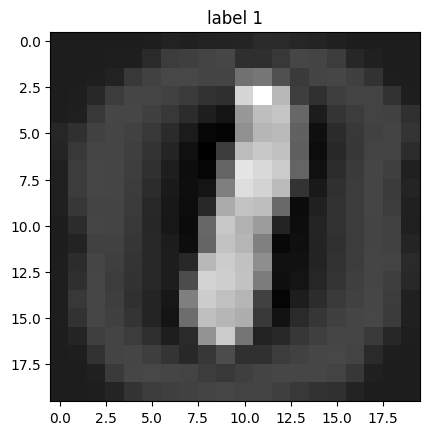

In [ ]:
# tester une image
c= 3
print (y_pred[c])
a = X_train[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Y_train[c]))
plt.imshow(a,cmap='gray')

##### Calling all metrics

In [111]:
accuracy = overall_accuracy(Y_train , y_pred) 
precision = overall_precision(Y_train, y_pred, 10) 
recall = overall_recall(Y_train, y_pred, 10)
FP_rate = overall_FP_rate(Y_train, y_pred,10)
print(f"Accuracy = {accuracy:.2f}, Precision = {precision:.2f}, Recall = {recall:.2f}, FP_rate = {f1:.2f}")
print(compute_confusion_matrix(Y_train,y_pred,10))



Accuracy = 1.00, Precision = 1.00, Recall = 1.00, FP_rate = 0.90
[[360   0   0   0   0   0   0   0   0   0]
 [  0 338   0   0   0   0   0   0   0   0]
 [  0   0 346   0   0   0   0   0   0   0]
 [  0   0   0 364   0   0   0   0   0   0]
 [  0   0   0   0 355   0   0   0   0   0]
 [  0   0   0   0   0 352   0   0   0   0]
 [  0   0   0   0   0   0 359   0   0   0]
 [  0   0   0   0   0   0   0 339   0   0]
 [  0   0   0   0   0   0   0   0 330   0]
 [  0   0   0   0   0   0   0   0   0 357]]


# Méthode 2: Arbres de décision


In [112]:
# Créer le modèle
model = DecisionTreeClassifier()
# Entrainer le modèle
model = model.fit(X_train, Y_train)
# Prediction
y_pred = model.predict(X_train)

8


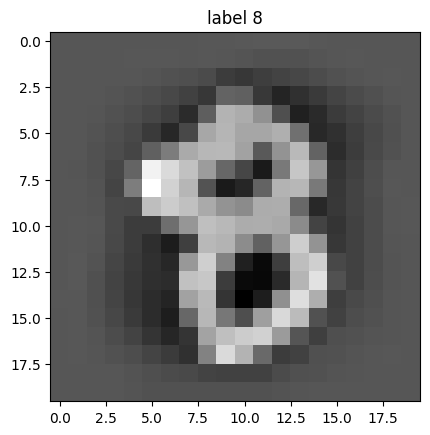

In [114]:
# tester une image
c= 3
print (y_pred[c])
a = X_train[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Y_train[c]))
plt.imshow(a,cmap='gray')

#### Metrics

In [115]:
accuracy = overall_accuracy(Y_train , y_pred) 
precision = overall_precision(Y_train, y_pred, 10) 
recall = overall_recall(Y_train, y_pred, 10)
FP_rate = overall_FP_rate(Y_train, y_pred,10)
print(f"Accuracy = {accuracy:.2f}, Precision = {precision:.2f}, Recall = {recall:.2f}, FP_rate = {f1:.2f}")
print(compute_confusion_matrix(Y_train,y_pred,10))



Accuracy = 1.00, Precision = 1.00, Recall = 1.00, FP_rate = 0.90
[[360   0   0   0   0   0   0   0   0   0]
 [  0 338   0   0   0   0   0   0   0   0]
 [  0   0 346   0   0   0   0   0   0   0]
 [  0   0   0 364   0   0   0   0   0   0]
 [  0   0   0   0 355   0   0   0   0   0]
 [  0   0   0   0   0 352   0   0   0   0]
 [  0   0   0   0   0   0 359   0   0   0]
 [  0   0   0   0   0   0   0 339   0   0]
 [  0   0   0   0   0   0   0   0 330   0]
 [  0   0   0   0   0   0   0   0   0 357]]


# Méthode 3: RN 
Réseaux de neurones Perceptron

In [116]:
model = MLPClassifier(solver='sgd', alpha=1e-5, hidden_layer_sizes=(25),max_iter=100000)
X_train, X_train, Y_train, Y_train = train_test_split(X, Y, random_state=0, test_size=0.7)
model.fit(X_train, Y_train)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=25, max_iter=100000, solver='sgd')

In [117]:
# Choisir un image de test 
c=0

In [118]:
model.predict([X_train[c,:]])

array([10])

In [119]:
# pour ROC, il faudra les probabilités:
model.predict_proba([X_train[c,:]])

array([[4.75535689e-57, 8.60409826e-74, 7.74768620e-87, 3.90135697e-63,
        9.63494717e-56, 3.53907791e-67, 1.98455374e-79, 6.01887517e-92,
        9.19013781e-13, 1.00000000e+00]])

Afficher l'image testée

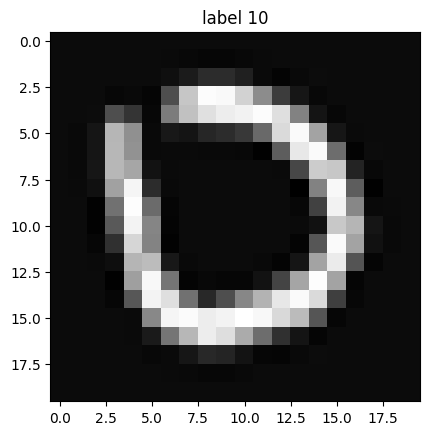

In [121]:
a = X_train[c,:].reshape((20, 20))
a=np.transpose(a)
plt.title('label '+ str(Y_train[c]))
plt.imshow(a,cmap='gray')

##### Metrics

In [ ]:
accuracy = overall_accuracy(Y_train , y_pred) 
precision = overall_precision(Y_train, y_pred, 10) 
recall = overall_recall(Y_train, y_pred, 10)
FP_rate = overall_FP_rate(Y_train, y_pred,10)
print(f"Accuracy = {accuracy:.2f}, Precision = {precision:.2f}, Recall = {recall:.2f}, FP_rate = {f1:.2f}")
print(compute_confusion_matrix(Y_train,y_pred,10))


Accuracy = 0.10, Precision = 0.10, Recall = 0.10, FP_rate = 0.90
[[38 40 29 46 35 34 30 33 30 36]
 [39 29 41 33 27 32 36 41 39 37]
 [34 30 28 49 32 38 37 40 35 35]
 [32 36 37 35 42 27 41 28 26 34]
 [40 31 38 34 38 39 35 28 42 26]
 [35 35 40 31 37 30 35 34 32 34]
 [36 32 25 39 36 34 35 34 39 40]
 [31 29 34 30 37 42 46 38 29 34]
 [39 38 34 37 38 35 32 28 32 38]
 [36 38 40 30 33 41 32 35 26 43]]


Plotting ROC curve for class 9



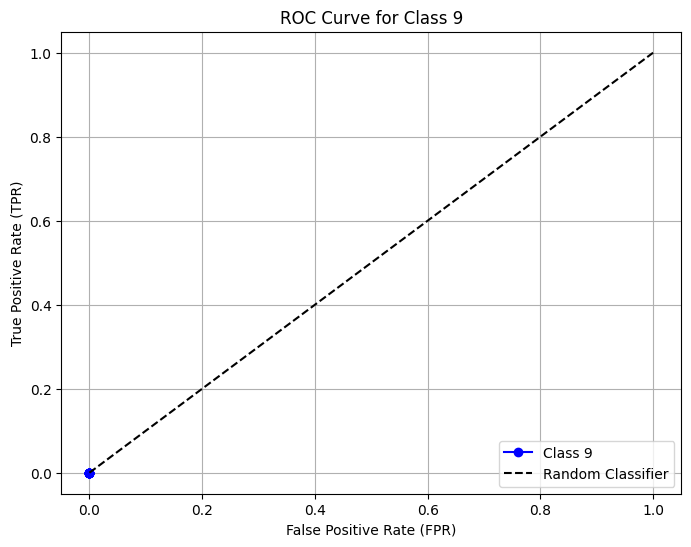

In [132]:
# plotting the roc curve for class c
import random
c = random.randint(1,10)
print(f'Plotting ROC curve for class {c}\n')
fpr_list, tpr_list = roc_curve(Y_test,y_pred,c)
plot_roc_curve(fpr_list, tpr_list,c)

# Méthode 4: RNC
Réseaux de Neurones Convolutifs

# Appliquer les métriques implementées pour voir le résultat